# 手写阿拉伯数字辨识 完整版

## 载入套件

In [1]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

## 设定参数

In [2]:
PATH_DATASETS = "Normalize" # 预设路径
BATCH_SIZE = 1024  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 步骤1：载入 MNIST 手写阿拉伯数字资料

In [3]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])


# 下载 MNIST 手写阿拉伯数字 训练资料
train_ds = MNIST(PATH_DATASETS, train=True, download=True, 
                 transform=transform)

# 下载测试资料
test_ds = MNIST(PATH_DATASETS, train=False, download=True, 
                 transform=transform)

# 训练/测试资料的维度
print(train_ds.data.shape, test_ds.data.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


In [4]:
# 训练资料前10笔图片的数字
train_ds.targets[:10]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [5]:
# 显示第1张图片内含值
train_ds.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [6]:
# 将非0的数字转为1，显示第1张图片
data = train_ds.data[0].clone()
data[data>0]=1
data = data.numpy()

# 将转换后二维内容显示出来，隐约可以看出数字为 5
text_image=[]
for i in range(data.shape[0]):
    text_image.append(''.join(data[i].astype(str)))
text_image

['0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000001111111111110000',
 '0000000011111111111111110000',
 '0000000111111111111111100000',
 '0000000111111111110000000000',
 '0000000011111110110000000000',
 '0000000001111100000000000000',
 '0000000000011110000000000000',
 '0000000000011110000000000000',
 '0000000000001111110000000000',
 '0000000000000111111000000000',
 '0000000000000011111100000000',
 '0000000000000001111100000000',
 '0000000000000000011110000000',
 '0000000000000011111110000000',
 '0000000000001111111100000000',
 '0000000000111111111000000000',
 '0000000011111111110000000000',
 '0000001111111111000000000000',
 '0000111111111100000000000000',
 '0000111111110000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000']

In [7]:
# 将非0的数字转为1，显示第2张图片
data = train_ds.data[1].clone()
data[data>0]=1
data = data.numpy()

# 将转换后二维内容显示出来，隐约可以看出数字为 5
text_image=[]
for i in range(data.shape[0]):
    text_image.append(''.join(data[i].astype(str)))
text_image

['0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000001111100000000',
 '0000000000000011111100000000',
 '0000000000000111111111000000',
 '0000000000011111111111000000',
 '0000000000011111111111000000',
 '0000000000111111111111000000',
 '0000000001111111110011100000',
 '0000000011111100000011100000',
 '0000000111111100000011100000',
 '0000000111100000000011100000',
 '0000000111000000000011100000',
 '0000001111000000000011100000',
 '0000001111000000001111100000',
 '0000001110000000011111000000',
 '0000001110000000111100000000',
 '0000001110000001111000000000',
 '0000001111111111111000000000',
 '0000001111111111100000000000',
 '0000001111111110000000000000',
 '0000000111111100000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000']

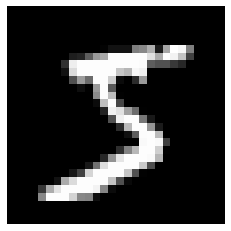

In [8]:
# 显示第1张图片图像
import matplotlib.pyplot as plt

# 第一笔资料
X = train_ds.data[0]

# 绘制点阵图，cmap='gray':灰阶
plt.imshow(X.reshape(28,28), cmap='gray')

# 隐藏刻度
plt.axis('off') 

# 显示图形
plt.show() 

## 步骤2：资料清理，此步骤无需进行

## 步骤3：进行特征工程，将特征缩放成(0, 1)之间

In [9]:
# train_ds.data = train_ds.data / 255.0
# test_ds.data = test_ds.data / 255.0

## 步骤4：资料分割，此步骤无需进行，载入MNIST资料时，已经切割好了

## 步骤5：建立模型结构

In [10]:
# 建立模型
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28 * 28, 256), 
    nn.Dropout(0.2),
    torch.nn.Linear(256, 10), 
    torch.nn.Softmax(dim=1)
).to(device)

## 步骤6：结合训练资料及模型，进行模型训练

In [11]:
epochs = 5
lr=0.1

# 建立 DataLoader
train_loader = DataLoader(train_ds, batch_size=600)

# 设定优化器(optimizer)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)

model.train()
loss_list = []    
for epoch in range(1, epochs + 1):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
#         if batch_idx == 0 and epoch == 1: print(data[0])

        optimizer.zero_grad()
        output = model(data)
#         loss = criterion(output, target)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            loss_list.append(loss.item())
            batch = batch_idx * len(data)
            data_count = len(train_loader.dataset)
            percentage = (100. * batch_idx / len(train_loader))
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}] ({percentage:.0f} %)' +
                  f'  Loss: {loss.item():.6f}')

Epoch 1: [    0 / 60000] (0 %)  Loss: -0.091698
Epoch 1: [ 6000 / 60000] (10 %)  Loss: -0.155576
Epoch 1: [12000 / 60000] (20 %)  Loss: -0.276606
Epoch 1: [18000 / 60000] (30 %)  Loss: -0.421791
Epoch 1: [24000 / 60000] (40 %)  Loss: -0.523165
Epoch 1: [30000 / 60000] (50 %)  Loss: -0.561051
Epoch 1: [36000 / 60000] (60 %)  Loss: -0.634950
Epoch 1: [42000 / 60000] (70 %)  Loss: -0.642817
Epoch 1: [48000 / 60000] (80 %)  Loss: -0.737179
Epoch 1: [54000 / 60000] (90 %)  Loss: -0.720192
Epoch 2: [    0 / 60000] (0 %)  Loss: -0.745703
Epoch 2: [ 6000 / 60000] (10 %)  Loss: -0.796556
Epoch 2: [12000 / 60000] (20 %)  Loss: -0.754041
Epoch 2: [18000 / 60000] (30 %)  Loss: -0.809160
Epoch 2: [24000 / 60000] (40 %)  Loss: -0.785422
Epoch 2: [30000 / 60000] (50 %)  Loss: -0.762914
Epoch 2: [36000 / 60000] (60 %)  Loss: -0.809599
Epoch 2: [42000 / 60000] (70 %)  Loss: -0.782476
Epoch 2: [48000 / 60000] (80 %)  Loss: -0.853580
Epoch 2: [54000 / 60000] (90 %)  Loss: -0.831651
Epoch 3: [    0 / 6000

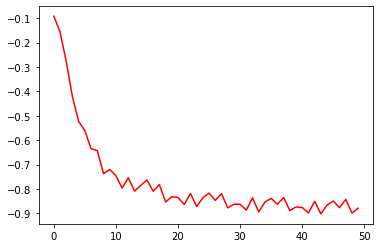

In [12]:
# 对训练过程的损失绘图
import matplotlib.pyplot as plt

plt.plot(loss_list, 'r')

## 步骤7：评分(Score Model)

In [14]:
# 建立 DataLoader
test_loader = DataLoader(test_ds, shuffle=False)

model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        # sum up batch loss
        test_loss += F.nll_loss(output, target).item()
        
        # 预测
        pred = output.argmax(dim=1, keepdim=True)  
        
        # 正确笔数
        correct += pred.eq(target.view_as(pred)).sum().item()

# 平均损失
test_loss /= len(test_loader.dataset)
# 显示测试结果
batch = batch_idx * len(data)
data_count = len(test_loader.dataset)
percentage = 100. * correct / len(test_loader)
print(f'平均损失: {test_loss:.4f}, 准确率: {correct}/{data_count}' + 
      f' ({percentage:.0f}%)\n')

平均损失: -0.8839, 准确率: 9047/10000 (90%)



In [15]:
# 实际预测 20 笔资料
predictions = []
with torch.no_grad():
    for i in range(20):
        data, target = test_ds[i][0], test_ds[i][1]
        data = data.reshape(1, *data.shape).to(device)
        output = torch.argmax(model(data), axis=-1)
        predictions.append(str(output.item()))

# 比对
print('actual    :', test_ds.targets[0:20].numpy())
print('prediction: ', ' '.join(predictions[0:20]))

actual    : [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
prediction:  7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4


In [27]:
# 显示第 9 笔的机率
import numpy as np

i=8
data = test_ds[i][0]
data = data.reshape(1, *data.shape).to(device)
#print(data.shape)
predictions = torch.softmax(model(data), dim=1)
print(f'0~9预测机率: {np.around(predictions.cpu().detach().numpy(), 2)}')
print(f'0~9预测机率: {np.argmax(predictions.cpu().detach().numpy(), axis=-1)}')

0~9预测机率: [[0.   0.   0.   0.   0.01 0.   0.99 0.   0.   0.  ]]
0~9预测机率: [6]


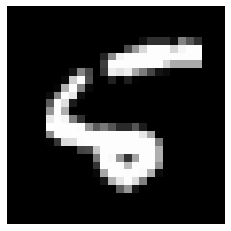

In [28]:
# 显示第 9 笔图像
X2 = test_ds[i][0] 
plt.imshow(X2.reshape(28,28), cmap='gray')
plt.axis('off')
plt.show() 

## 步骤8：评估，暂不进行

## 步骤9：模型布署

In [29]:
# 模型存档
torch.save(model, 'model.pth')

# 模型载入
model = torch.load('model.pth')

## 步骤10：新资料预测

In [30]:
# 使用小画家，绘制 0~9，实际测试看看
from skimage import io
from skimage.transform import resize
import numpy as np

# 读取影像并转为单色
for i in range(10):
    uploaded_file = f'./myDigits/{i}.png'
    image1 = io.imread(uploaded_file, as_gray=True)

    # 缩为 (28, 28) 大小的影像
    image_resized = resize(image1, (28, 28), anti_aliasing=True)    
    X1 = image_resized.reshape(1,28, 28) #/ 255.0

    # 反转颜色，颜色0为白色，与 RGB 色码不同，它的 0 为黑色
    X1 = torch.FloatTensor(1-X1).to(device)

    # 预测
    predictions = torch.softmax(model(X1), dim=1)
    # print(np.around(predictions.cpu().detach().numpy(), 2))
    print(f'actual/prediction: {i} {np.argmax(predictions.detach().cpu().numpy())}')

actual/prediction: 0 6
actual/prediction: 1 1
actual/prediction: 2 2
actual/prediction: 3 0
actual/prediction: 4 4
actual/prediction: 5 5
actual/prediction: 6 6
actual/prediction: 7 3
actual/prediction: 8 8
actual/prediction: 9 8


## 其他：显示模型汇总资讯(summary)、绘制图形显示模型结构

In [31]:
# 显示模型的汇总资讯
for name, module in model.named_children():
    print(f'{name}: {module}')

0: Flatten(start_dim=1, end_dim=-1)
1: Linear(in_features=784, out_features=256, bias=True)
2: Dropout(p=0.2, inplace=False)
3: Linear(in_features=256, out_features=10, bias=True)


## PyTorch 无法绘制模型